# Baseline

We have chosen **U-Net** as the baseline for this project. Inspired by the Karpathy's recipe, we first tried to obtain as much as possible without involving any fanciness or regularization technique,
exploring the (already many) available hyperparameters. Then, we applied data augmentation and schedulers to regularize our overfitted results.

## Dataset

Before diving deep with the selected model, we must create the dataset which we will use to train it.

In [1]:
from utils import set_deterministic

set_deterministic(42)

In [2]:
img_size = 256
images_path = '../data/images'
masks_path = '../data/masks'
device='cpu'

In [3]:
import itertools
from preprocess.dataset import get_training_validation_sets, denormalize_images
from visualization import visualize

hubmap_mean = [0.65459856, 0.48386562, 0.69428385]
hubmap_std = [0.15167958, 0.23584107, 0.13146145]

train_dataset, _, val_dataset, _ = get_training_validation_sets(
    images_path=images_path,
    masks_path=masks_path,
    validation_percentage=0.25,
    transform={'train': None, 'val': None},
    device=device,
    mean=hubmap_mean,
    std=hubmap_std
)

If our dataset has been created correctly, we should be able to inspect some samples of it.

Training Dataset contains 2757 samples.
Validation Dataset contains 919 samples.


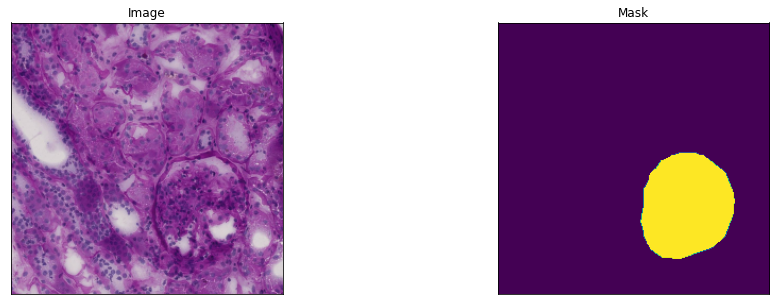

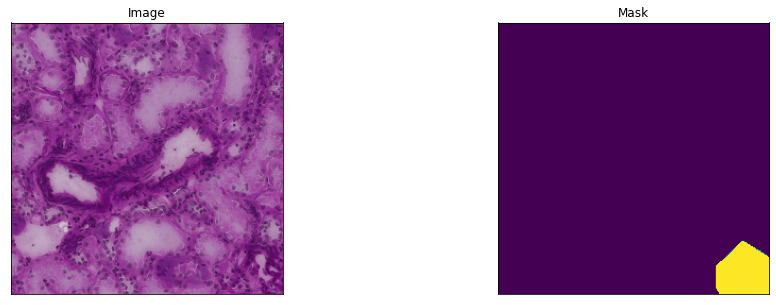

In [4]:
print(f"Training Dataset contains {len(train_dataset)} samples.")
print(f"Validation Dataset contains {len(val_dataset)} samples.")

num_samples=2
for image, mask in itertools.islice(train_dataset, 0, num_samples):
    visualize(
        image=denormalize_images(image, hubmap_mean, hubmap_std), 
        mask=mask.to(device)
    )

## U-Net

For the U-Net implementation, we relied on the `segmentation-models-pytorch` library.
Since it provides many pretrained backbones, we tried some of them taking into account:

* Transfer learning
* Backbone model
* Depth and number of channels in the decoder

### Transfer Learning

Given we consider our dataset fairly small, we tried to follow the general rule of using a pretrained model exploiting the transfer learning technique.

We began training some models freezing the pretrained backbones and normalizing the images with the ImageNet's mean and std.
We freezed the entire backbone and then only most of its layers.

Probably due to the domain difference between the dataset used to pretrain the models (ImageNet) and ours, these approaches were not particularly successful.  

As expected, we obtained worse results compared to retraining the backbone and normalizing with mean and std of HuBMAP dataset.  
Since we noticed that retraining from existing weights was computationally feasible for most of the architectures, we moved towards this direction.

### Encoder

We focused our attention on:

* ResNet backbones, in particular ResNet34 and ResNet50, which are among the most widely used in this context.
* EfficientNet backbones, in particular with $\theta$ = 0, 3 and 5. We didn't go further also because computational limitations stopped us.

We mainly carried out experiments training these models with Adam on the 256x256 dataset.
We also tried the 512x512 one observing only slower computations. The right compromise between efficiency, memory utilization and results obtained has been identified in **EfficientNet-B0**.  

For a detailed comparison of most of the models tested, you can refer to our dedicated [W&B project](https://wandb.ai/lomb/hackingthekidney-unet).

### Decoder

The default values used in the library are depth 5 and decoder output channels with values 256, 128, 64, 32 and 16. After some runs, we asked ourselves if that was too much, since we were observing that the models were able to reach acceptable results in few epochs getting stucked in the following ones. Even if there could be other reasons like the learning rate or the optimizer, we thought that these default values were set to deal with dozens of classes and images with higher variation in representation, while in our case we have only two classes and quite indistinguishable patterns.

We exasperated these observations by training an EfficientNet-B0 with 32, 16, 8, 4, 2 channels in the decoder and batches of 96 samples. Its results confirmed these predictions: not only performances were similar to the previous more complex models but metrics and losses were finally more gentle and stable.  
Parallel to this, we also tried to decrease the depth leaving an higher number of channels, obtaining comparable performances but less stable plots.  
Combining both observations led to strange results: by decreasing even slightly the depth (from 5 to 4) leaving the above number of channels, we noticed that the model was unable to learn.

On the other hand, if we observe previous works based on U-Net, the architecture seems not to change from a dataset to another. For example, the same authors propose the U-Net architecture for cell segmentation and dental X-Ray segmentation using the same identical model (excluding the final layer) even if the latter domain has 7 classes and the first only 2.

However, we have also to take into account that even if the original work is focused on the medical domain, the dataset is still very different from ours, and our encoders are stronger than the simple convolutions applied by the classical U-Net at each level. For example if we consider EfficientNet, each block has an inverted residual block and a squeeze and excitation module, which should improve the capabilities.

In the end, we opted for **5 channels** as in the default implementation, but we reduced considerably the number of **output channels** from 256-16 to **64-4**, since they were able to gain similar results in a more gentle way.  
The other approaches were also valid but in our opinion more difficult to train, tune and analyze.

Decreasing the depth rarely brought benefits, and we think this is coherent with theoretical motivations behind the concept of depth in encoder-decoder segmentation models. Even with complex models and large number of layers, depths lower than 4 are not able to extract the information, and their performances often stuck.

Obviously, we have to take into account that also the learning rate plays an important role in speed and performances. During the above process we slightly changed it to confirm the observations.

In [6]:
from models.unet import get_unet
from torchsummary import summary

encoder = 'efficientnet-b0'
depth = 5
channels = [64, 32, 16, 8, 4]

unet, _ = get_unet(device=device,
                   encoder=encoder,
                   depth=depth,
                   decoder_channels=channels,
                   freeze_backbone=False)

# summary(unet, input_size=(3, img_size, img_size))

## Training

To ensure reproducibility, here it is described the methodology with which we have performed the training of all the different model variations we have discussed so far. Since we always performed these steps on *Google Colab* for harware limitations, here we are going to load the weights of the model of interest instead of retraining it from scratch.

### Loss Function

After having tried several variations of both the *Binary Dice Loss* and the *Binary Focal Loss*, we decided to use a linear combination of them, assigning consistently more weight (3x) to the latter.

In [7]:
from training.loss_functions import *

def get_loss_function(focal_weight: float = 0.75, dice_weight: float = 0.25):
    binary_cross_entropy = BinaryFocalLoss(gamma=0.0,
                                           alpha=0.5,
                                           device=device)
    binary_dice_loss = BinaryDiceLoss()
    return CombinationLoss([
        {'name': binary_cross_entropy, 'weight': focal_weight}, 
        {'name': binary_dice_loss, 'weight': dice_weight}
    ])

### Loop

The class `Trainer` is responsible of properly loading the dataset during instantiation and its `train` method deals with the training and validation loop. You can configure it as you prefer, for instance in order to use or not services like *W&B* and/or *TensorBoard*.  

`TrainerVerbosity` defines the level of the detail of the outputs during the training and evaluation processes.

In [8]:
lr = 1e-3
epochs = 20
threshold = 0.5
batch_size = 64

In [ ]:
from training.loop import Trainer, TrainerVerbosity
from torch.optim import Adam

trainer_base = Trainer(threshold,
                       batch_size,
                       train_dataset,
                       val_dataset)

trainer_base.train(
    model=unet,
    criterion=get_loss_function(),
    optimizer=Adam(unet.parameters(), lr=lr, weight_decay=0),
    epochs=epochs,
    scheduler=None,
    early_stopping=None,
    verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS],
    evaluation_verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS]
);

In [9]:
unet.load_state_dict(torch.load('unet_base.pt', map_location=torch.device(device)))

<All keys matched successfully>

You can see the charts corresponding to the training of the model we have just loaded at this [link](https://wandb.ai/mazzio97/hackingthekidney-report/runs/5zd392d4).  

The model has clearly overfitted the training data, in fact validation metrics are pretty oscillatory across the epochs.

### Predictions

Being the training/validation split non deterministic when we run it, it is impossible to know which images were in the train and which in the val datasets during the training of the model loaded. Therefore, we can not appreciate the difference in predictions accuracy between the two sets.  

However, if you are running the notebook and you have executed the training loop, you can appreciate this difference using the same method presented here.

Some good predictions:



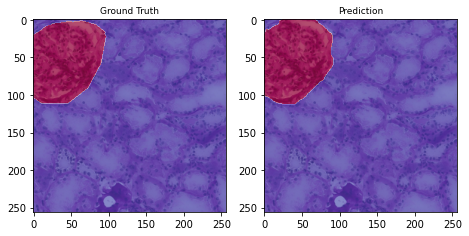

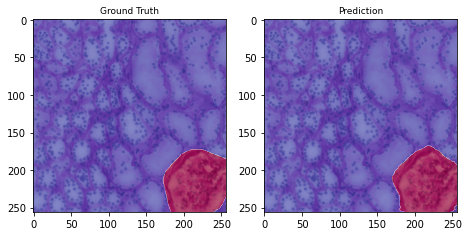

Some bad predictions:



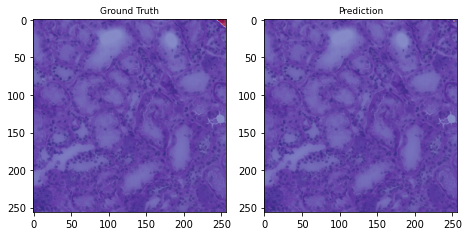

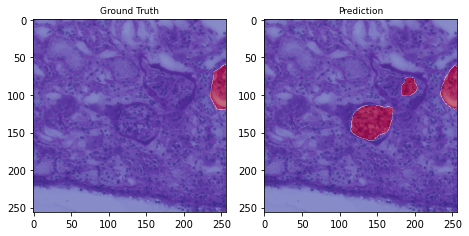

In [10]:
from evaluation.show_predictions import show_predictions

print("Some good predictions:\n")

show_predictions(
    model=unet, 
    images_path=images_path, 
    masks_path=masks_path, 
    images_to_show=2,
    mean=hubmap_mean, 
    std=hubmap_std,
    min_score_percentage=90,
    max_score_percentage=99
)

print("Some bad predictions:\n")

show_predictions(
    model=unet, 
    images_path=images_path, 
    masks_path=masks_path,
    images_to_show=2,
    mean=hubmap_mean, 
    std=hubmap_std,
    min_score_percentage=1,
    max_score_percentage=30
)

## Regularization

In order to avoid overfitting, we performed various regularization techniques, hoping to reduce the current huge gap (>10% both in *IoU* and *Dice Coefficient*) between the performances of training and validation.  

Specifically, we used the following approaches:

* **Data Augmentation**
* **Learning Rate Scheduler**
* **Early Stopping** 

### Dataset

We need to recreate the train/val datasets because this time we want to stochastically perform the transformations described in the *Prerequisites* section when an image is retrieved.

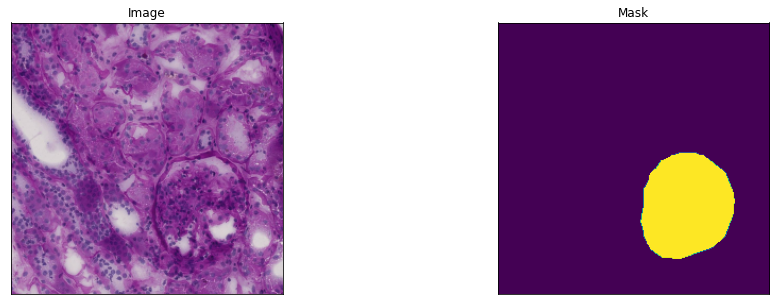

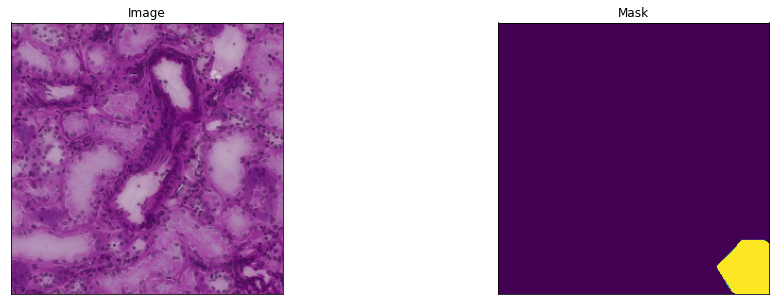

In [11]:
from preprocess.augmentation import get_augmentations

train_dataset_augmented, _, val_dataset, _ = get_training_validation_sets(
    images_path=images_path,
    masks_path=masks_path,
    validation_percentage=0.25,
    transform={'train': get_augmentations(), 'val': None},
    device=device,
    mean=hubmap_mean,
    std=hubmap_std
)

for image, mask in itertools.islice(train_dataset_augmented, 0, num_samples):
    visualize(image=denormalize_images(image, hubmap_mean, hubmap_std), mask=mask.cpu())

### Model

The model structure is exactly the same as the one we created above, but obviously we need to recreate it because the previous has already been trained.

In [12]:
unet_regularized, _ = get_unet(device=device,
                               encoder=encoder,
                               depth=depth,
                               decoder_channels=channels,
                               freeze_backbone=False)

The LR scheduler chosen for this model is `StepLR` but also `ReduceLROnPlateau` has been tested; both due to the fact that most models seem to reach a plateau in few epochs and get stucked there.

Moreover, we have decided to stop the training after a fixed number of epochs if validation metrics were not improving.

Another regularization technique we wanted to include but decided to avoid is *L2*: setting the `weight_decay` even to really small values ($10^{-4}$) degrades the results significantly.

In [ ]:
from torch.optim.lr_scheduler import StepLR
from training.loop import EarlyStopping

optimizer = Adam(unet_regularized.parameters(), lr=lr, weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

trainer_regularized = Trainer(threshold,
                              batch_size,
                              train_dataset_augmented,
                              val_dataset)

trainer_regularized.train(
    model=unet_regularized,
    criterion=get_loss_function(),
    optimizer=optimizer,
    epochs=epochs,
    scheduler=scheduler,
    early_stopping=EarlyStopping(num_epochs_to_stop=3),
    verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS],
    evaluation_verbosity_level=[TrainerVerbosity.PROGRESS, TrainerVerbosity.STATISTICS]
);

As we did earlier, for simplicity reasons, we load the already trained model without performing the loop.

In [13]:
unet_regularized.load_state_dict(torch.load('unet_regularized.pt', map_location=torch.device(device)))

<All keys matched successfully>

You can see the charts corresponding to the training of the model we have just loaded at this [link](https://wandb.ai/mazzio97/hackingthekidney-report/runs/2dhtvc43).  

Differently from the non regularized version, this presents smoother charts with a really small difference in performance between training and validation. Regularization seems to have done its job correctly.

### Predictions

As we did for the previous model, we provide few tangible examples of the capabilities of the regularized U-Net.

Some good predictions:



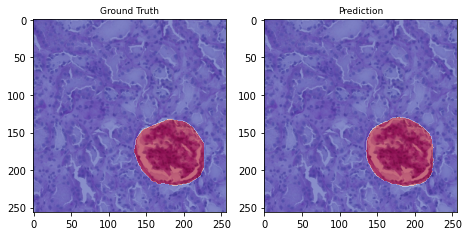

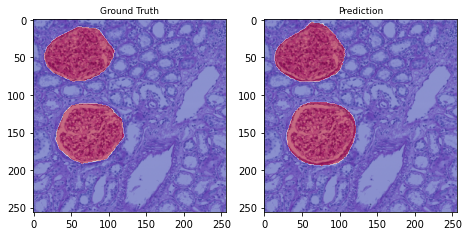

Some bad predictions:



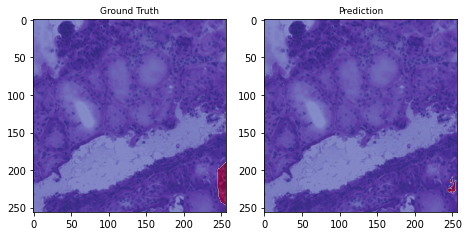

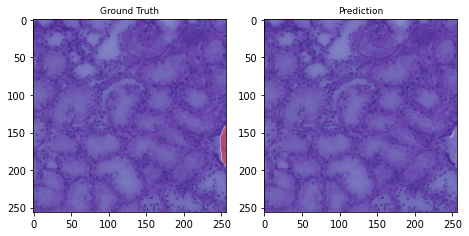

In [14]:
print("Some good predictions:\n")

show_predictions(
    model=unet_regularized, 
    images_path=images_path, 
    masks_path=masks_path, 
    images_to_show=2,
    mean=hubmap_mean, 
    std=hubmap_std,
    min_score_percentage=90,
    max_score_percentage=99
)

print("Some bad predictions:\n")

show_predictions(
    model=unet_regularized, 
    images_path=images_path, 
    masks_path=masks_path,
    images_to_show=2,
    mean=hubmap_mean, 
    std=hubmap_std,
    min_score_percentage=1,
    max_score_percentage=30
)

## Conclusions

U-Net is a widely used architecture and there are tons of alternative implementations and enhancements available, like U-Net++. We stopped our exploration here in favor of other architectures considered state of the art in the domain of segmentation.

We would like also to consider that obtaining and training a good model is not enough to reach better performances, for example also post processing is crucial, a wrong thresholding may hide any little improvements. In the U-Net paper they talk about 10 different levels of thresholding and 3 types of errors involved to analyze the results. 